## STN测试报告
以公开mnist数据集为例做训练，比较有stn模块和没有stn模块的网络两者性能的差异

In [1]:
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import imgaug as ia
from datetime import datetime
from math import cos, sin, pi

In [2]:
# 加载数据集
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 归一化
x_train, x_test = x_train / 255.0, x_test / 255.0
# reshape
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
# 获取图像的长宽
H, W,_ = x_train[0].shape

### 数据增强
生成一些数据增强的数据，数据增强的方法是仿射变换与原数据构成新的训练集

In [3]:
# Apply affine transformations to some of the images
# - scale to 80-120% of image height/width (each axis independently)
# - translate by -20 to +20 relative to height/width (per axis)
# - rotate by -45 to +45 degrees
# - shear by -16 to +16 degrees
# - order: use nearest neighbour or bilinear interpolation (fast)
# - mode: use any available mode to fill newly created pixels
#         see API or scikit-image for which modes are available
# - cval: if the mode is constant, then use a random brightness
#         for the newly created pixels (e.g. sometimes black,
#         sometimes white)
seq = iaa.Sequential([
    iaa.OneOf([
        iaa.Affine(
            scale={"x": (0.6, 1.1), "y": (0.5, 1.1)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-30, 30),
            shear=(-15, 15),
            order=[0, 1],
            cval=(0),
        ),
        iaa.Affine(
            scale={"x": (0.6, 1.1), "y": (0.6, 1.1)},
            order=[0, 1],
            cval=(0),
        ),
        iaa.Affine(
            scale={"x": (0.6, 0.8), "y": (0.6, 0.8)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            order=[0, 1],
            cval=(0),
        ),
        iaa.Affine(
            rotate=(-60, 60),
            #shear=(-30, 30),
            order=[0, 1],
            cval=(0),
        ),
        iaa.Affine(
            shear=(-40, 40),
            order=[0, 1],
            cval=(0),
        ),
    ]
    )
])
x_train_aug = seq(images=x_train)  
x_test_aug = seq(images=x_test)  

### 可视化
可视化训练集的函数

In [4]:
from math import ceil
def draw_samples(images, images_per_row=5):
    num = len(images)
    per_row = min(images_per_row, num)
    rows = ceil(num /per_row)
    fig, axs = plt.subplots(rows, per_row)
    count = 0 
    for i in range(rows):
        
        for j in range(images_per_row):
            count+=1
            if (count > num):
                break
            if rows == 1:
                axs[j+i*per_row].imshow(images[j+i*per_row], cmap='gray')
            else:
                axs[i,j].imshow(images[j+i*per_row], cmap='gray')
            
    plt.show()

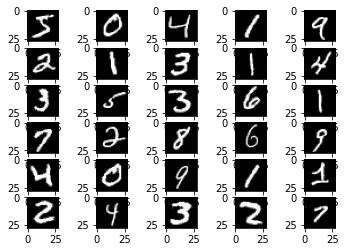

In [5]:
# 原数据集数据
draw_samples(x_train[:30])

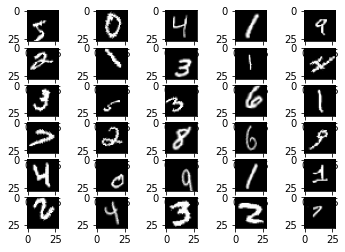

In [6]:
# 仿射变换的数据
draw_samples(x_train_aug[:30])

### 神经网络
定义简单的密集神经网络进行训练

In [7]:
# baseline
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(H, W)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 定义损失函数
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
# completely retrain the original model with mnist dataset + distorted mnist dataset
model.fit(tf.concat([x_train_aug, x_train],0), tf.concat([y_train, y_train],0), epochs=5)

Epoch 1/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.9359 - accuracy: 0.7041
Epoch 2/5
3750/3750 [==============================] - 4s 987us/step - loss: 0.4982 - accuracy: 0.8430
Epoch 3/5
3750/3750 [==============================] - 4s 1ms/step - loss: 0.4187 - accuracy: 0.8673
Epoch 4/5
3750/3750 [==============================] - 4s 1ms/step - loss: 0.3788 - accuracy: 0.8810
Epoch 5/5
3750/3750 [==============================] - 4s 1ms/step - loss: 0.3533 - accuracy: 0.8883


In [11]:
# not good for distorted data
print('distorted data:',model.evaluate(x_test_aug, y_test))
# still good for undistorted original data
print('undistorted original data:',model.evaluate(x_test, y_test))

313/313 [==============================] - 0s 929us/step - loss: 0.5379 - accuracy: 0.8329
distorted data: [0.5378811955451965, 0.8328999876976013]
313/313 [==============================] - 0s 663us/step - loss: 0.0755 - accuracy: 0.9776
undistorted original data: [0.07546955347061157, 0.9775999784469604]


定义STN模块的网络进行训练

In [13]:
from stn_module import stn_module
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Input,Dropout
def model(input_shape):
    inputs = Input(input_shape)
    inputs_stn = stn_module(inputs)
    x = Conv2D(6, (3,3),padding='valid',activation="relu")(inputs_stn)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(16, (3,3),padding='valid',activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
    x = Dense(84, activation='relu')(x)
    x = Dense(10)(x)
    return tf.keras.Model(inputs, x)
st= model(input_shape=(H, W, 1))
st.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 24, 24, 14)   364         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 12, 12, 14)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 8, 8, 32)     11232       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [15]:
# 训练
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
st.compile(optimizer="adam",
              loss=loss_fn,
              metrics=['accuracy'])
st.fit(tf.concat([x_train_aug, x_train],0), tf.concat([y_train, y_train],0), epochs=5)

Epoch 1/5
3750/3750 [==============================] - 76s 20ms/step - loss: 0.4957 - accuracy: 0.8421
Epoch 2/5
3750/3750 [==============================] - 76s 20ms/step - loss: 0.1169 - accuracy: 0.9625
Epoch 3/5
3750/3750 [==============================] - 74s 20ms/step - loss: 0.0902 - accuracy: 0.9719
Epoch 4/5
3750/3750 [==============================] - 72s 19ms/step - loss: 0.0817 - accuracy: 0.9746
Epoch 5/5
3750/3750 [==============================] - 73s 19ms/step - loss: 0.0713 - accuracy: 0.9778


In [16]:
# 评估模型
print('undistorted origin data:', st.evaluate(x_test, y_test))
print('distorted data:', st.evaluate(x_test_aug, y_test))

313/313 [==============================] - 3s 9ms/step - loss: 0.0346 - accuracy: 0.9900
undistorted origin data: [0.034552980214357376, 0.9900000095367432]
313/313 [==============================] - 3s 9ms/step - loss: 0.1000 - accuracy: 0.9684
distorted data: [0.1000135987997055, 0.9684000015258789]
